In [25]:
import uproot as up
import zfit
import mplhep as hep
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load hist
file = up.open("/sps/cms/jxiao/hgg/dyturbo/fit/crystal_test.root")
h_zmass = file["s_m"].to_hist()

h_zmass
# get bin edges
xaxis_edges=h_zmass.axes.edges[0]

In [23]:
# convert to zfit data
# h_zmass.axes.name
h_zmass.axes.name = ("mass",) # rename the axes
binned_data = zfit.data.BinnedData.from_hist(h_zmass)

# model parameter settings
obs = zfit.Space("mass", xaxis_edges[0],xaxis_edges[-1])

## Gauss
# mu = zfit.Parameter("mu", 91., 90, 92)
# sigma = zfit.Parameter("sigma", 1, 0.1, 2)
# model_nobin = zfit.pdf.Gauss(mu, sigma, obs)

## Double-sided Crystall 
mu = zfit.Parameter("mu", 91., 85, 95)
sigma = zfit.Parameter("sigma", 2, 0.1, 2.5)
alphal = zfit.Parameter("alphal",1,0,3)
nl = zfit.Parameter("nl",3,0,6)
alphar = zfit.Parameter("alphar",1,0,3)
nr = zfit.Parameter("nr",3,0,6)
model_nobin = zfit.pdf.DoubleCB(
    mu,
    sigma,
    alphal,
    nl,
    alphar,
    nr,
    obs
)

# make binned
binning = zfit.binned.VariableBinning(xaxis_edges, name="mass")
obs_bin = zfit.Space("mass", binning=binning)

model = model_nobin.to_binned(obs_bin)
loss = zfit.loss.BinnedNLL(model, binned_data)

# do fit
minimizer = zfit.minimize.Minuit(gradient=True)
result = minimizer.minimize(loss)
result.hesse()
print(result)

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7faffc288c20>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fafb47e13d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00017 │ -15692034.87 | -1.569151e+07 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
mu                 91.1722  +/-  0.0019       False
sigma              1.14137  +/-  0.0031       False
alphal             1.20907  +/-  0.0042       False
nl                 1.67053  +/-   0.007       False
alphar             1.12305

In [63]:
r

<method-wrapper '__getattribute__' of FitResult object at 0x7fafb4367230>

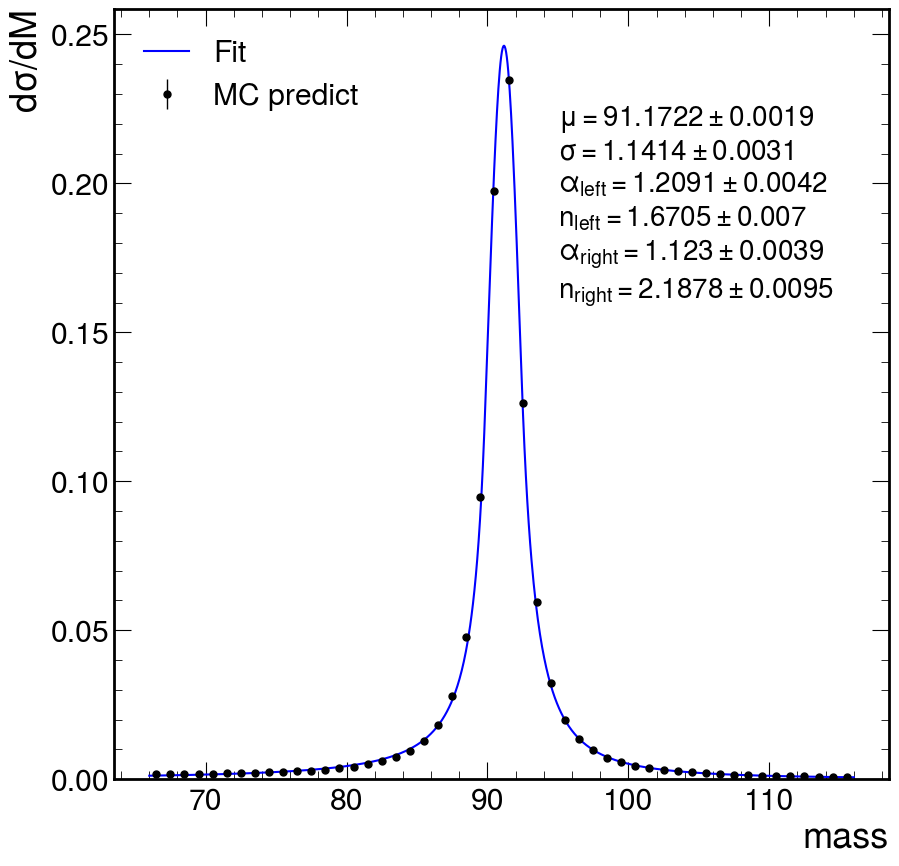

In [62]:
param_dict = {
    "mu":{
        "label": "\\mu",
        "value": result.params.get("mu")["value"],
        "error": result.params.get("mu")["hesse"]["error"]
    },
    "sigma":{
        "label": "\\sigma",
        "value": result.params.get("sigma")["value"],
        "error": result.params.get("sigma")["hesse"]["error"]
    },
    "alphal":{
        "label": "\\alpha_{left}",
        "value": result.params.get("alphal")["value"],
        "error": result.params.get("alphal")["hesse"]["error"]
    },
    "nl":{
        "label": "n_{left}",
        "value": result.params.get("nl")["value"],
        "error": result.params.get("nl")["hesse"]["error"]
    },
    "alphar":{
        "label": "\\alpha_{right}",
        "value": result.params.get("alphar")["value"],
        "error": result.params.get("alphar")["hesse"]["error"]
    },
    "nr":{
        "label": "n_{right}",
        "value": result.params.get("nr")["value"],
        "error": result.params.get("nr")["hesse"]["error"]
    }
}

hep.style.use(hep.style.CMS) 

f, ax = plt.subplots(figsize=(10,10))

# plot the data as a histogramm
hep.histplot(binned_data, yerr=True, density=True, color='black', histtype='errorbar',label="MC predict")

# evaluate the func at multiple x and plot
x_plot = np.linspace(obs.v1.lower, obs.v1.upper, num=1000)
y_plot = model_nobin.pdf(x_plot)
plt.plot(x_plot, y_plot, color='blue',label="Fit")
plt.legend(loc="upper left")
plt.text(
    95, 0.15, 
r"""
${}={}\pm{}$
${}={}\pm{}$
${}={}\pm{}$
${}={}\pm{}$
${}={}\pm{}$
${}={}\pm{}$
""".format(
        param_dict["mu"]["label"],np.round(param_dict["mu"]["value"],4),np.round(param_dict["mu"]["error"],4),
        param_dict["sigma"]["label"],np.round(param_dict["sigma"]["value"],4),np.round(param_dict["sigma"]["error"],4),
        param_dict["alphal"]["label"],np.round(param_dict["alphal"]["value"],4),np.round(param_dict["alphal"]["error"],4),
        param_dict["nl"]["label"],np.round(param_dict["nl"]["value"],4),np.round(param_dict["nl"]["error"],4),
        param_dict["alphar"]["label"],np.round(param_dict["alphar"]["value"],4),np.round(param_dict["alphar"]["error"],4),
        param_dict["nr"]["label"],np.round(param_dict["nr"]["value"],4),np.round(param_dict["nr"]["error"],4)
    ),
    fontsize=20
)

plt.ylabel(r"$d\sigma / d M$")
plt.show()


In [48]:
binned_data